# COGS 108 - Data Checkpoint

# Names

- Nhan Quach
- Joseph Morales
- Victor Wang
- Kevin Hu
- Areen Lu

<a id='research_question'></a>
# Research Question

How has social perception of profanity shifted across the past 20 years as indicated by the proportion of profane words utilized within the top 10 movies over the past 20 years and their respective age ratings, box office performance, and review scores?

# Dataset(s)

[The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) contains metadata for 45,000 movies with 26 million ratings collected from 270,000 users for all movies stored within there. However, this dataset is limited only up till 2017. The dataset is gathered from [The Movie Database](https://www.themoviedb.org/) which is a community built move and TV database for movies from 2008 till now. We could update the original dataset to be current till 2022, however the IMDB API is limited to 40 fetches per second and [it was calculated to take roughly an entire week](https://www.themoviedb.org/talk/54f41aafc3a3683455000991) to fetch all necessary data.

[List of films that most frequently use the word F*](https://www.kaggle.com/datasets/devrimtuner/list-of-films-that-most-frequently-use-the-word) is as the title suggests. Movies on the list stretch as far back as 1983 to as recent as 2022. The only profane word studied on the dataset, however, is F*.

# Setup

In [ ]:
# Importing necessary libraries
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os

# Import for matplotlibs
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.style  as style

# Import libraries for webscraping
from bs4 import BeautifulSoup as bs
import requests
import sys
import os

# Import libraries for word analysis
import string
import nltk
from nltk.corpus        import stopwords
from nltk.stem.snowball import SnowballStemmer

# Load stop words for script preprocessing
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) # words such as "the", "a", "an", etc

# Import libraries for parallel processing
from concurrent.futures import ThreadPoolExecutor

# Data Cleaning

Datasets gathered through the [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) were initially stored locally as they exceeded GitHub's limit on large file sizes. To preserve consistency and anonimity of our local repositories, we will be referring to the location of this data set as `kaggle/input`, however this will also be the name of the directory within the repository where we will upload the wrangled data.

We are primarily interested in the meta_data associated with the movies from [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset), so we will import that and perform a brief inspection of the type of data stored within the file. Each of the small preview files from [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) are unnecessary, so we will remove those along with the keywords and credits files. 

While [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) contains movie review scores based on voters from [The Movies Database](https://www.themoviedb.org/documentation/api?language=en-US) platform, there is not enough documentation to determine if it is viable. Furthermore, the `ratings.csv` file which [The Movies Dataset]() utilizes is based off of [MovieLens](https://grouplens.org/datasets/movielens/) which has conducted reserach with 270,000 users to gather 26 million ratings for all the movies within [The Movies Dataset](). However, the `ratings.csv` coded their movies utilizing their own method, as described in [MovieLens](https://grouplens.org/datasets/movielens/) documentation. It can be retraced through linking the `links.csv` file to the movie IDs stored within [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset).

**Key Points**:

* `movies_metadata.csv` is relevant
* `List of films that most frequently use...` is relevant
* Movie ratings will be based off of `ratings.csv` which is aggregated from [MovieLens](https://grouplens.org/datasets/movielens/), but needs to be linked to the movies via `links.csv`

In [2]:
# Read in csv files of interest
meta_data  = pd.read_csv('kaggle/input/The Movies Dataset\movies_metadata.csv', low_memory=False)
ratings    = pd.read_csv('kaggle/input/The Movies Dataset/ratings.csv', low_memory=False)
links      = pd.read_csv('kaggle/input/The Movies Dataset\links.csv', low_memory=False)

print('Meta-data Observations: ' + str(len(meta_data.index)))
print('Ratings Observations: '   + str(len(ratings.index)))
print('Links Observations: '     + str(len(links.index)))

Meta-data Observations: 45466
Ratings Observations: 26024289
Links Observations: 45843


In [3]:
# Gather columns within ratings to identify which columns may be dropped
column_names = list(ratings.columns)
print(column_names)

['userId', 'movieId', 'rating', 'timestamp']


In [4]:
# Remove timestamp as that is unnecessary
ratings.drop(labels='timestamp', axis='columns', inplace=True)

# Get the number of reviews per movie
review_count = ratings.groupby('movieId')\
                      .size()            \
                      .reset_index(name='review_count')

# Get the aggregate score of reviews for the movies
ratings      = ratings.groupby('movieId')     \
                      .agg({'rating': 'mean'})\
                      .reset_index()

# Merge the two prior dataframes together as the new ratings
ratings      = ratings.merge(review_count, on='movieId')

# Link the movie links with ratings
ratings      = ratings.merge(links, on='movieId')

print('Ratings Observations: ' + str(len(ratings.index)))
ratings.head()

Ratings Observations: 45115


,movieId,rating,review_count,imdbId,tmdbId
0,1,3.888157,66008,114709,862.0
1,2,3.236953,26060,113497,8844.0
2,3,3.175550,15497,113228,15602.0
3,4,2.875713,2981,114885,31357.0
4,5,3.079565,15258,113041,11862.0


Now, let's view the `meta_data` dataframe to see what type of information we have from there.

In [5]:
meta_data.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


From here, we will want to list out the names of the columns within meta_data as they are currently stored within the dataframe to identify columns of particular interest which would be relevant to keep.

**Key Points:**
* Lots of columns stored within `meta_data`, so we will need to trim down to relevant columns

In [6]:
# Gather column names to discover which columns may be relevant
column_names = list(meta_data.columns)
print(column_names)

['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']


We would not want to include movies which have not been released, so we will remove those entries from the table. For now, we will keep the `adult` column until we can find a more accurate method of pairing the age rating with the movie.

**Key Points:**
* `adult`, `genres`, `release_date`, `revenue`, `title`, `imdb_id` all appear to be relevant columns
* Want to ensure we include movies which have been released from the dataset
* Want to ensure we include movies which are in English

In [7]:
# Remove movies which have never been released
meta_data = meta_data[(meta_data['status'] == 'Released') & (meta_data['original_language'] == 'en')]

print('Observations: ' + str(len(meta_data.index)))

Observations: 31952


In [8]:
# Preserve relevant columns
column_names = ['adult', 'genres', 'release_date', 'revenue', 'title', 'imdb_id']
meta_data = meta_data[column_names]

# Drop any rows with null values according to the columns we preserved
meta_data.dropna(how='any', inplace=True)

print('Observations: ' + str(len(meta_data.index)))

meta_data.head()

Observations: 31885


,adult,genres,release_date,revenue,title,imdb_id
0,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,373554033.0,Toy Story,tt0114709
1,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,262797249.0,Jumanji,tt0113497
2,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,0.0,Grumpier Old Men,tt0113228
3,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,81452156.0,Waiting to Exhale,tt0114885
4,False,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,76578911.0,Father of the Bride Part II,tt0113041


We can already see something strange with one movie titled **Grumpier Old Men** as it was somehow released, yet made 0 in revenue. Furthermore, we can see the `imdb_id` is represented as a string, rather than an `int` which will conflict when we attempt to merge the dataframes together. We also do not require the release date to have as much granularity as it currently does, so let us truncate that to just the year and ensure that it is a numeric datatype.

**Key Points:**
* Some movies made $0 in revenue, which we should exclude
* Release dates should be truncated to only be representing of the year for the purposes of our analysis
* `imdb_id` needs to be converted into an `int`

In [9]:
# Convert the release date to only be the year
meta_data['release_date'] = pd.to_datetime(meta_data['release_date']).dt.year
meta_data['imdb_id']      = meta_data['imdb_id'].str.replace(r'\D',  '', regex=True).astype('int64')

# Match the imdb_id column to that within ratings
meta_data.rename(columns={'imdb_id':'imdbId'}, inplace = True)

meta_data.dtypes

adult            object
genres           object
release_date      int64
revenue         float64
title            object
imdbId            int64
dtype: object

In [10]:
# Merge metadata and ratings via imdbId
meta_data = meta_data.merge(ratings, on='imdbId')

meta_data.head()

,adult,genres,release_date,revenue,title,imdbId,movieId,rating,review_count,tmdbId
0,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995,373554033.0,Toy Story,114709,1,3.888157,66008,862.0
1,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995,262797249.0,Jumanji,113497,2,3.236953,26060,8844.0
2,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995,0.0,Grumpier Old Men,113228,3,3.175550,15497,15602.0
3,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995,81452156.0,Waiting to Exhale,114885,4,2.875713,2981,31357.0
4,False,"[{'id': 35, 'name': 'Comedy'}]",1995,76578911.0,Father of the Bride Part II,113041,5,3.079565,15258,11862.0


In [11]:
# Drop movies which have no movieId, hence have no matching entities
meta_data = meta_data[meta_data['movieId'].notna()]

# Drop movies which did not make any money
meta_data = meta_data[(meta_data['revenue'] > 0)]

print('Observations: ' + str(len(meta_data.index)))

meta_data.head()

Observations: 6339


,adult,genres,release_date,revenue,title,imdbId,movieId,rating,review_count,tmdbId
0,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995,373554033.0,Toy Story,114709,1,3.888157,66008,862.0
1,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995,262797249.0,Jumanji,113497,2,3.236953,26060,8844.0
3,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995,81452156.0,Waiting to Exhale,114885,4,2.875713,2981,31357.0
4,False,"[{'id': 35, 'name': 'Comedy'}]",1995,76578911.0,Father of the Bride Part II,113041,5,3.079565,15258,11862.0
5,False,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",1995,187436818.0,Heat,113277,6,3.841764,27895,949.0


In [12]:
# Drop the ID columns besides imdbId as they are no longer needed
meta_data = meta_data.drop(['movieId', 'tmdbId'], axis='columns')
meta_data.head()

,adult,genres,release_date,revenue,title,imdbId,rating,review_count
0,False,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995,373554033.0,Toy Story,114709,3.888157,66008
1,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995,262797249.0,Jumanji,113497,3.236953,26060
3,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995,81452156.0,Waiting to Exhale,114885,2.875713,2981
4,False,"[{'id': 35, 'name': 'Comedy'}]",1995,76578911.0,Father of the Bride Part II,113041,3.079565,15258
5,False,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",1995,187436818.0,Heat,113277,3.841764,27895


In [13]:
# Get a description of the values within meta_data
meta_data.describe()

,release_date,revenue,imdbId,rating,review_count
count,6339.000000,6.339000e+03,6.339000e+03,6339.000000,6339.000000
mean,1998.763685,7.721924e+07,7.732563e+05,3.165128,3331.969869
std,15.685323,1.558439e+08,1.002789e+06,0.520045,7287.903792
min,1915.000000,1.000000e+00,4.972000e+03,0.500000,1.000000
25%,1991.000000,3.329019e+06,1.025310e+05,2.854132,150.000000
50%,2003.000000,2.062737e+07,3.033610e+05,3.219474,682.000000
75%,2010.000000,7.838059e+07,1.214397e+06,3.538648,2940.000000
max,2017.000000,2.787965e+09,6.574272e+06,5.000000,91921.000000


With the maximum amount of reviews for a movie being in the 90 thousands, yet the minimum being in the 1s, let's check the distribution of the `review_count` to get a better perspective of the distribution. Too few reviews for a movie can arbitrarily skew the rating.

**Key Points:**
* `review_count` has large outliers on the high-end, and it is difficult to determine its distribution currently without visualization

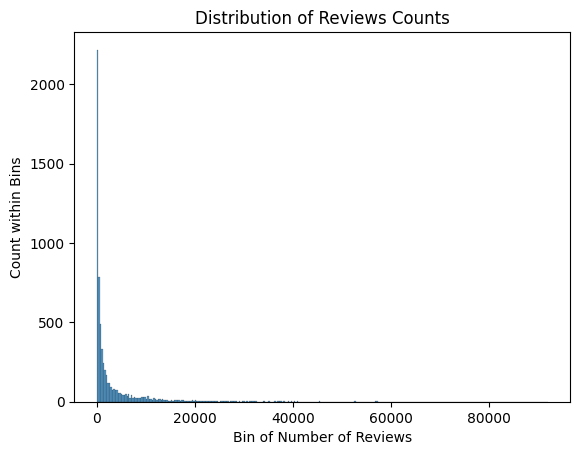

In [14]:
# Visualize the distribution of votes as a histogram
review_count_dist = sns.histplot(data=meta_data['review_count']) \
                       .set(xlabel='Bin of Number of Reviews', 
                            ylabel='Count within Bins', 
                            title ='Distribution of Reviews Counts')

Visualizing this distribution, we can clearly see that the distribution of reviews is skewed towards the right. In that case, we will establish that a movie which has 100 reviews from anonymous online reviewers would be a reasonable number of reviews to trust the review score. 

**Key Points:**
* The distribution is strongly skewed right
* We will decide that 100 reviews is the minimum number of voters which a movie needs to have a reasonable review score which is not skewed due to a small vote size

In [15]:
# Drop movies which have less than 100 reviews
meta_data         = meta_data[meta_data['review_count'] >= 100]

In [16]:
print('Observations: ' + str(len(meta_data.index)))

meta_data.describe()

Observations: 5045


,release_date,revenue,imdbId,rating,review_count
count,5045.000000,5.045000e+03,5.045000e+03,5045.000000,5045.000000
mean,1998.307235,9.443482e+07,6.475555e+05,3.226403,4177.432706
std,14.857263,1.691149e+08,8.628410e+05,0.485523,7952.159235
min,1915.000000,1.000000e+00,4.972000e+03,0.880342,100.000000
25%,1991.000000,9.000000e+06,1.026870e+05,2.922857,406.000000
50%,2002.000000,3.352684e+07,2.582730e+05,3.274544,1195.000000
75%,2009.000000,1.039117e+08,9.746610e+05,3.585987,4222.000000
max,2017.000000,2.787965e+09,5.442430e+06,4.429015,91921.000000


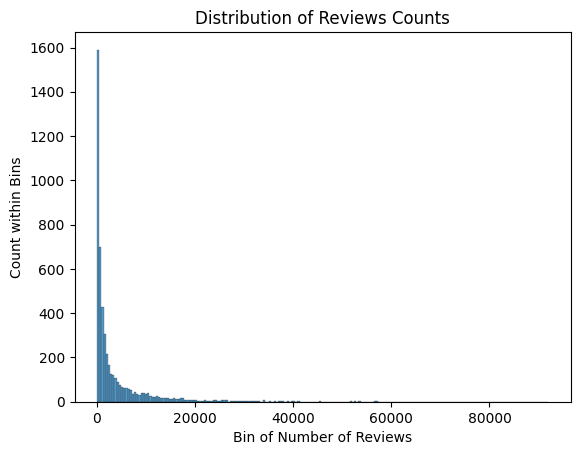

In [17]:
# Visualize the distribution of votes as a histogram
review_count_dist = sns.histplot(data=meta_data['review_count']) \
                       .set(xlabel='Bin of Number of Reviews', 
                            ylabel='Count within Bins', 
                            title ='Distribution of Reviews Counts')

While the distribution of reviews is still skewed right, at the very minimum a movie has 100 reviews and we will trust review ratings with at least 100 reviews.

**Key Points:**
* Skew of review distribution is the same, but the minimum number of votes a movie has is 100 which is reasonably reliable

Let's see review how our dataframe is currently, and see which years for movies we do not have data on

In [18]:
# Review which years our table has movies for

min_year             = meta_data['release_date'].min()
max_year             = meta_data['release_date'].max()
all_years            = list(range(min_year, max_year+1))
years_with_movies    = meta_data['release_date'].unique()
years_with_no_movies = set(all_years) - set(years_with_movies)

print(years_with_no_movies)

{1920, 1922, 1926, 1928, 1930, 1943, 1916, 1917, 1918, 1919}


As we can see, all years which have no movies is prior to the 20 year threshold we wanted to set. Since we do not have access to the years 2018-onward, we will limit the "last 20 years" to be relative to 2017.

**Key Points:**
* Remove movies from prior to 20 years ago, relative 2017

In [19]:
meta_data = meta_data[meta_data['release_date'] >= (2017 - 20)]

print('Observations: ' + str(len(meta_data.index)))

meta_data.head()

Observations: 3210


,adult,genres,release_date,revenue,title,imdbId,rating,review_count
739,False,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",1997,33956608.0,The Relic,120004,2.815600,2359
833,False,"[{'id': 18, 'name': 'Drama'}]",1997,3028094.0,Dangerous Ground,118927,2.640086,232
839,False,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",1997,294064.0,Bliss,118742,3.185567,291
904,False,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",1997,2154540.0,Shadow Conspiracy,120107,2.773481,362
1140,False,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",1997,1179002.0,Nightwatch,119791,3.100465,861


Let's now get a count of how many movies we have per year.

In [20]:
meta_data['release_date'].value_counts().sort_index()

1997    130
1998    126
1999    133
2000    122
2001    136
2002    149
2003    142
2004    158
2005    175
2006    200
2007    177
2008    176
2009    182
2010    186
2011    196
2012    155
2013    170
2014    177
2015    153
2016    141
2017     26
Name: release_date, dtype: int64

## Metadata and Reviews Complete

Now, we have essentially gotten the metadata of our movies to a point which is usable. The next thing we need to do is gather script data for each movie. To our knowledge, this is not readaly available, so we will perform webscraping on [Springfield! Springfield!](https://www.springfieldspringfield.co.uk/movie_scripts.php) a website which contains the dialogue scripts of over 36,000 movies.

In [21]:
# Create a subdirectory to store movie scripts
if not os.path.exists('scripts'):
    os.makedirs('scripts')

In [28]:
def scrape_and_preprocess_script(row):
    # Set up requests session
    session = requests.Session()
    session.headers.update({'User-Agent': 'Mozilla/5.0'})
    
    # Gather the list of movies currently within metadata
    row = row[1]
    title        = row['title']
    year         = row['release_date']
    imdbID       = row['imdbId']
    title_search = f"{title} ({year})"
    alt_title    = f"{title.split(' ')[1]}, The ({year})" if title.startswith('The') else title_search

    # Format the name of the movies in a format compatible with the search function
    search_format = title.replace(" ", "+")

    # Get relevant links and forms to search for the things
    scripts_url  = 'https://www.springfieldspringfield.co.uk/'
    search_url   = 'movie_scripts.php'
    search_query = {'search': title_search}

    # Make a request to search for the movie within the webdatabase
    response = session.get(scripts_url + search_url, params=search_query)

    # Parse through serach results and get the url of the script page
    if response.status_code == 200:
        soup         = bs(response.content 'html.parser')
        result_links = soup.select('a[href^="/movie_script.php?movie="]')
    
        # Find the link that matches that movie name
        if result_links:
            for link in result_links:
                
                # Or condition added because of the way Springfield! Springfield! handles movie titles
                if title_search in link.text or alt_title in link.text:
                    script_url = scripts_url + link['href']
                    print(script_url)
                    row['has_script'] = True
                    break
            else:
                print(f"No results found for {title_search}")
                row['has_script'] = False
                return
                
    else:
        print(f"Search request failed with status code {response.status_code}")
        return

    # Make a request to the script page and get the HTML content
    if 'script_url' in locals():
        response = session.get(script_url)
    if response.status_code == 200:
    
        # Parse the script page and extract the script text
        soup             = bs(response.content, 'lxml')
        script_container = soup.find('div', class_='scrolling-script-container')
    
        # Perform script scraping if the script exists
        if script_container:
            script_lines = script_container.get_text('\n', strip=True)
        
            # Preprocess the script text
            
            # Lowercase all the words
            script_lines     = script_lines.lower()
            # Remove all punctuation
            script_lines     = script_lines.translate(str.maketrans('','', string.punctuation))
            # Convert the string into a collection of singular words
            words            = nltk.word_tokenize(script_lines)
            # Remove all stop words such as "the", "a", "an", etc
            words            = [word for word in words if (word not in stop_words)]
            # Reduce all words into their stemmed form
            stemmer          = SnowballStemmer(language='english')
            # Stem each word
            words            = [stemmer.stem(word) for word in words]
            # Finish preprocessing by joining all the words
            processed_script = ' '.join(words)
        
            # Save script to file
            filename = f"scripts/{imdbID}.txt"
            with open(filename, 'w') as f:
                f.write(processed_script)
            print(f"Saved script for '{title_search}' to {filename}")
            
            # Get and store the size of the script
            script_size = os.path.getsize(filename)
            row['script_size'] = script_size
            
        else:
            row['has_script'] = False
    else:
        print(f"Script request failed with status code {response.status_code}")
        return

In [29]:
# Create a ThreadPoolExecutor to process scripts in parallel
executor = ThreadPoolExecutor(max_workers=8)

# Use the ThreadPoolExecutor to execute the function on each row
results  = list(executor.map(scrape_and_preprocess_script, meta_data.iterrows()))

executor.shutdown()

https://www.springfieldspringfield.co.uk//movie_script.php?movie=shadow-conspiracy
https://www.springfieldspringfield.co.uk//movie_script.php?movie=dangerous-ground
No results found for Bliss (1997)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=relic-the
https://www.springfieldspringfield.co.uk//movie_script.php?movie=murder-at-1600
https://www.springfieldspringfield.co.uk//movie_script.php?movie=nightwatch
https://www.springfieldspringfield.co.uk//movie_script.php?movie=fierce-creatures
https://www.springfieldspringfield.co.uk//movie_script.php?movie=turbulence
Saved script for 'Shadow Conspiracy (1997)' to scripts/120107.txt
Saved script for 'Dangerous Ground (1997)' to scripts/118927.txt
Saved script for 'The Relic (1997)' to scripts/120004.txt
Saved script for 'Nightwatch (1997)' to scripts/119791.txt
Saved script for 'Murder at 1600 (1997)' to scripts/119731.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=metro
Saved script for 'Turbulence (

https://www.springfieldspringfield.co.uk//movie_script.php?movie=fire-down-below
https://www.springfieldspringfield.co.uk//movie_script.php?movie=game-the
No results found for The Ice Storm (1997)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=chasing-amy
Saved script for 'Fire Down Below (1997)' to scripts/119123.txt
Saved script for 'The Game (1997)' to scripts/119174.txt
No results found for Def Jam's How to Be a Player (1997)
No results found for The Full Monty (1997)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=i-know-what-you-did-last-summer
https://www.springfieldspringfield.co.uk//movie_script.php?movie=the-devils-advocate
https://www.springfieldspringfield.co.uk//movie_script.php?movie=playing-god
Saved script for 'Chasing Amy (1997)' to scripts/118842.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=the-house-of-yes
https://www.springfieldspringfield.co.uk//movie_script.php?movie=washington-square
No results found for 

Saved script for 'The Newton Boys (1998)' to scripts/120769.txt
No results found for The Big One (1997)
Saved script for 'The Object of My Affection (1998)' to scripts/120772.txt
No results found for Lost in Space (1998)
No results found for The Spanish Prisoner (1997)
No results found for My Giant (1998)
No results found for City of Angels (1998)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=he-got-game
https://www.springfieldspringfield.co.uk//movie_script.php?movie=zero-effect
No results found for An Alan Smithee Film: Burn, Hollywood, Burn (1998)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=species-ii
https://www.springfieldspringfield.co.uk//movie_script.php?movie=major-league-back-to-the-minors
No results found for Wild Man Blues (1997)
Saved script for 'Species II (1998)' to scripts/120841.txt
Saved script for 'Zero Effect (1998)' to scripts/120906.txt
No results found for Dancer, Texas Pop. 81 (1998)
https://www.springfieldspringfield.co.u

Saved script for 'Bride of Chucky (1998)' to scripts/144120.txt
Saved script for 'Practical Magic (1998)' to scripts/120791.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=american-history-x
Saved script for 'Happiness (1998)' to scripts/147612.txt
No results found for Living Out Loud (1998)
Saved script for 'Soldier (1998)' to scripts/120157.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=gods-and-monsters
https://www.springfieldspringfield.co.uk//movie_script.php?movie=siege-the
https://www.springfieldspringfield.co.uk//movie_script.php?movie=waterboy-the
https://www.springfieldspringfield.co.uk//movie_script.php?movie=elizabeth
Saved script for 'American History X (1998)' to scripts/120586.txt
Saved script for 'Gods and Monsters (1998)' to scripts/120684.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=i-still-know-what-you-did-last-summer
https://www.springfieldspringfield.co.uk//movie_script.php?movie=velvet-goldmine
ht

Saved script for 'The Mummy (1999)' to scripts/120616.txt
Saved script for 'Star Wars: Episode I - The Phantom Menace (1999)' to scripts/120915.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=limbo
No results found for Twice Upon a Yesterday (1998)
No results found for The Thirteenth Floor (1999)
Saved script for 'Notting Hill (1999)' to scripts/125439.txt
No results found for The Red Violin (1998)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=austin-powers-the-spy-who-shagged-me
https://www.springfieldspringfield.co.uk//movie_script.php?movie=tarzan
Saved script for 'Limbo (1999)' to scripts/164085.txt
Saved script for 'Austin Powers: The Spy Who Shagged Me (1999)' to scripts/145660.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=the-generals-daughter
https://www.springfieldspringfield.co.uk//movie_script.php?movie=big-daddy
Saved script for 'Tarzan (1999)' to scripts/120855.txt
No results found for An Ideal Husband (1999)
h

Saved script for 'Sleepy Hollow (1999)' to scripts/162661.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=flawless-1999
Saved script for 'Dogma (1999)' to scripts/120655.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=ride-with-the-devil
https://www.springfieldspringfield.co.uk//movie_script.php?movie=tumbleweeds
Saved script for 'Toy Story 2 (1999)' to scripts/120363.txt
Saved script for 'Flawless (1999)' to scripts/155711.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=deuce-bigalow-male-gigolo
No results found for The End of the Affair (1999)
Saved script for 'Ride with the Devil (1999)' to scripts/134154.txt
No results found for The Green Mile (1999)
Saved script for 'Tumbleweeds (1999)' to scripts/161023.txt
No results found for The Cider House Rules (1999)
Saved script for 'Deuce Bigalow: Male Gigolo (1999)' to scripts/205000.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=bicentennial-man
https:/

https://www.springfieldspringfield.co.uk//movie_script.php?movie=big-mommas-house
Saved script for 'Mission: Impossible II (2000)' to scripts/120755.txt
No results found for Gone in Sixty Seconds (2000)
Saved script for 'Shanghai Noon (2000)' to scripts/184894.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=boys-and-girls
No results found for Love's Labour's Lost (2000)
Saved script for 'Big Momma's House (2000)' to scripts/208003.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=shaft
https://www.springfieldspringfield.co.uk//movie_script.php?movie=titan-a-e
https://www.springfieldspringfield.co.uk//movie_script.php?movie=chicken-run
Saved script for 'Boys and Girls (2000)' to scripts/204175.txt
Saved script for 'Titan A.E. (2000)' to scripts/120913.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=me-myself-irene
https://www.springfieldspringfield.co.uk//movie_script.php?movie=patriot-the
Saved script for 'Shaft (2000)' to sc

Saved script for 'Miss Congeniality (2000)' to scripts/212346.txt
Saved script for 'O Brother, Where Art Thou? (2000)' to scripts/190590.txt
Saved script for 'Dracula 2000 (2000)' to scripts/219653.txt
No results found for Thirteen Days (2000)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=traffic
No results found for Shadow of the Vampire (2000)
No results found for Antitrust (2001)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=save-the-last-dance
https://www.springfieldspringfield.co.uk//movie_script.php?movie=panic
https://www.springfieldspringfield.co.uk//movie_script.php?movie=pledge-the
https://www.springfieldspringfield.co.uk//movie_script.php?movie=sugar-spice
Saved script for 'Traffic (2000)' to scripts/181865.txt
No results found for The Wedding Planner (2001)
Saved script for 'Save the Last Dance (2001)' to scripts/206275.txt
Saved script for 'Panic (2000)' to scripts/194218.txt
Saved script for 'The Pledge (2001)' to scripts/237572.txt
h

https://www.springfieldspringfield.co.uk//movie_script.php?movie=session-9
Saved script for 'Rush Hour 2 (2001)' to scripts/266915.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=captain-corellis-mandolin
https://www.springfieldspringfield.co.uk//movie_script.php?movie=rat-race
Saved script for 'Osmosis Jones (2001)' to scripts/181739.txt
Saved script for 'American Pie 2 (2001)' to scripts/252866.txt
Saved script for 'American Outlaws (2001)' to scripts/244000.txt
Saved script for 'Session 9 (2001)' to scripts/261983.txt
No results found for Jay and Silent Bob Strike Back (2001)
Saved script for 'Captain Corelli's Mandolin (2001)' to scripts/238112.txt
Saved script for 'Rat Race (2001)' to scripts/250687.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=ghosts-of-mars
https://www.springfieldspringfield.co.uk//movie_script.php?movie=summer-catch
No results found for An American Rhapsody (2001)
No results found for Happy Accidents (2000)
No results

https://www.springfieldspringfield.co.uk//movie_script.php?movie=john-q
Saved script for 'Big Fat Liar (2002)' to scripts/265298.txt
Saved script for 'Collateral Damage (2002)' to scripts/233469.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=return-to-never-land
Saved script for 'Crossroads (2002)' to scripts/275022.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=super-troopers
Saved script for 'Hart's War (2002)' to scripts/251114.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=dragonfly
Saved script for 'John Q (2002)' to scripts/251160.txt
Saved script for 'Return to Never Land (2002)' to scripts/280030.txt
Saved script for 'Dragonfly (2002)' to scripts/259288.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=queen-of-the-damned
Saved script for 'Super Troopers (2001)' to scripts/247745.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=we-were-soldiers
https://www.springfieldspringf

https://www.springfieldspringfield.co.uk//movie_script.php?movie=s1m0ne
https://www.springfieldspringfield.co.uk//movie_script.php?movie=undisputed
No results found for FearDotCom (2002)
Saved script for 'One Hour Photo (2002)' to scripts/265459.txt
Saved script for 'Serving Sara (2002)' to scripts/261289.txt
Saved script for 'S1m0ne (2002)' to scripts/258153.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=swimfan
No results found for City By The Sea (2002)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=barbershop
Saved script for 'Undisputed (2002)' to scripts/281322.txt
Saved script for 'Swimfan (2002)' to scripts/283026.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=igby-goes-down
Saved script for 'Barbershop (2002)' to scripts/303714.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=transporter-the
https://www.springfieldspringfield.co.uk//movie_script.php?movie=ballistic-ecks-vs-sever
https://www.sprin

Saved script for 'Confessions of a Dangerous Mind (2002)' to scripts/270288.txt
No results found for Blue Collar Comedy Tour: The Movie (2003)
https://www.springfieldspringfield.co.uk//movie_script.php?movie=just-married
https://www.springfieldspringfield.co.uk//movie_script.php?movie=a-guy-thing
https://www.springfieldspringfield.co.uk//movie_script.php?movie=national-security
https://www.springfieldspringfield.co.uk//movie_script.php?movie=biker-boyz
Saved script for 'Confessions of a Dangerous Mind (2002)' to scripts/270288.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=final-destination-2
Saved script for 'Just Married (2003)' to scripts/305711.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=may
Saved script for 'National Security (2003)' to scripts/271668.txt
https://www.springfieldspringfield.co.uk//movie_script.php?movie=recruit-the
Saved script for 'Biker Boyz (2003)' to scripts/326769.txt
Saved script for 'A Guy Thing (2003)' to scrip

KeyboardInterrupt: 

https://www.springfieldspringfield.co.uk//movie_script.php?movie=old-school


Now that we've wrangled all the available scripts we could gather, let's read in the script files we gathered to add additional details about the length of scripts for each movie and whether or not the movie had an available script.

In [25]:
meta_data.head()

,adult,genres,release_date,revenue,title,imdbId,rating,review_count
739,False,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",1997,33956608.0,The Relic,120004,2.815600,2359
833,False,"[{'id': 18, 'name': 'Drama'}]",1997,3028094.0,Dangerous Ground,118927,2.640086,232
839,False,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",1997,294064.0,Bliss,118742,3.185567,291
904,False,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",1997,2154540.0,Shadow Conspiracy,120107,2.773481,362
1140,False,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",1997,1179002.0,Nightwatch,119791,3.100465,861
